# Multi-agent Paperbot

Multi-agent supervisor

In [2]:
%%capture --no-stderr
%pip install -U langgraph lanchain_community langchain_ollama langchain_experimental

In [12]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")


## Create tools
An agent to retrieve with a vector DB, and one agent to code algorithm

In [13]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_experimental.utilities.python import PythonREPL

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your result."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n \'\'\'python\n{code}\n \'\'\'\nStdout: {result}"
    return result_str

In [14]:

from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.tools.retriever import create_retriever_tool
from langchain_chroma import Chroma
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader


### 논문 삽입 ###
file_path = "./example_data/2408.00714v1.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()



### 대형언어모델, 메모리, 파서 설정 ###
parser = StrOutputParser()
llm = ChatOllama(model="Llama3.2-Korean")
memory = MemorySaver()
embedding = "snowflake-arctic-embed2"


### 리트리버 생성 ###
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OllamaEmbeddings(model=embedding))

retriever = vectorstore.as_retriever()



### 리트리버툴 구축 ###
retriever_tool = create_retriever_tool(
    retriever,
    "paper_retriever",
    "Searches and returns excerpts from a paper.",
)




### Create Agent Supervisor
Choosing the next worker node OR finish processing

In [15]:
from langgraph.graph import MessagesState

In [16]:
# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str

In [17]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOpenAI(model="gpt-4o-mini")


def supervisor_node(state: AgentState) -> AgentState:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END

    return {"next": next_}

## Construct Graph
The stat and worker nodes 

In [18]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

llm = ChatOllama(model="Llama3.2-Korean")

research_agent = create_react_agent(llm, 
                                    tools = [retriever_tool], 
                                    checkpointer=memory, 
                                    state_modifier="You are a researcher. DO NOT do any math.")
config = {"configurable": {"thread_id": "abc123"}}


def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state, config=config)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="researcher")
        ]
    }


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
llm = ChatOllama(model="command-r7b")

code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: AgentState) -> AgentState:
    result = code_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="coder")]
    }


builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)

Connet all the edges in the graph.

In [19]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    builder.add_edge(member, "supervisor")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
builder.add_conditional_edges("supervisor", lambda state: state["next"])
# Finally, add entrypoint
builder.add_edge(START, "supervisor")

graph = builder.compile()

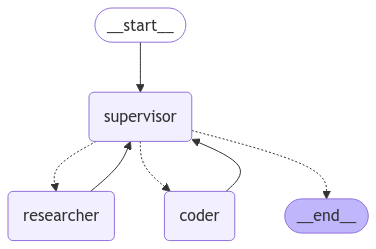

In [20]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

In [ ]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")